In [136]:
%matplotlib inline

import numpy as np
import pandas as pd
tls.set_credentials_file(username='kevllino', api_key='ji1c5fp7w0')
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

## Data Collection 

In [125]:
sample_data = pd.read_csv("data/sample_data.csv")
costs_data = pd.read_csv("data/costs_data.csv")
auction_parcels = pd.read_csv("data/auction_parcels.csv")
elevation_data = pd.read_csv("data/elevation_data.csv")

In [126]:
sample_data[["gold_available"]].head()

,gold_available
0,3901.517878
1,17523.530328
2,4537.823944
3,21601.105930
4,21186.862192


## Data Preprocessing and exploration

We first enriched the sample data with the elevation feature, then we mapped the continuous values to one of the 2 x 3 elevation categories for fixed and variable costs: 

### Elevation for Fixed Costs
<ul>
<li><b>Low Elevation</b>: 	Elevation < 0m </li>
<li><b>Medium Elevation</b>: 0m < Elevation <= 500m</li>
<li><b>High Elevation</b>: Elevation > 500m</li>
</ul>

### Elevation for Variable Costs
<ul>
<li><b>Low Elevation</b>: 	Elevation < 0m </li>
<li><b>Medium Elevation</b>: 0m < Elevation <= 700m</li>
<li><b>High Elevation</b>: Elevation > 700m</li>
</ul>

In [127]:
elevation = elevation_data.drop(["Easting","Northing"],axis = 1)
sample = sample_data.merge(elevation, on="parcel_id")

In [128]:
def map_to_fixed_elevation(row, threshold): 
    if row["elevation"]  < 0: 
        return 0 
    elif row["elevation"] > 0 and row["elevation"]  <= threshold: 
        return 1 
    elif row["elevation"] > threshold: 
        return 2
    

In [129]:
sample["fixed_cost"] = sample.apply(lambda row: map_to_fixed_elevation(row, 500), axis = 1)
sample["variable_cost"] = sample.apply(lambda row: map_to_fixed_elevation(row, 700), axis = 1)
sample.describe()

,parcel_id,Easting,Northing,Pyerite,Mexallon,Tritanium,Megacyte,Nocxium,Isogen,Veldspar,...,Spudumain,Gneiss,Arkonor,Mercoxit,Bistot,Crokite,gold_available,elevation,fixed_cost,variable_cost
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,11261.941400,74.891400,75.077000,114.690044,108.480667,107.407900,111.709613,112.205520,114.327617,105.865743,...,146.831750,113.603848,106.709769,111.338126,112.268864,108.443991,12374.911196,409.016811,1.215000,1.075200
std,6425.913782,43.521685,42.837907,22.387161,6.932708,9.674488,18.352131,9.765217,17.217109,5.258676,...,21.673469,11.787317,7.383663,7.666121,11.790360,5.671461,6067.684876,503.698083,0.771034,0.703736
min,4.000000,0.500000,0.500000,19.856209,84.861319,66.911702,29.903756,75.707857,22.157819,91.864452,...,51.141385,73.248565,76.066022,86.084987,62.569692,87.749107,2357.148816,-1359.020531,0.000000,0.000000
25%,5748.750000,37.500000,38.500000,100.682505,103.575101,101.260272,100.226674,105.278671,103.227686,102.217591,...,131.925339,105.378566,101.736307,105.736392,104.255459,104.359193,7199.592697,62.409200,1.000000,1.000000
50%,11200.500000,74.500000,74.500000,112.257269,107.522212,106.145377,109.758230,110.890648,112.481474,105.049074,...,145.573532,111.751614,105.857703,110.418789,110.704721,107.633955,11902.142387,411.031675,1.000000,1.000000
75%,16754.000000,112.500000,111.500000,127.363743,112.453893,112.600010,121.856395,117.995928,123.523854,108.912550,...,160.569686,120.323985,110.831962,115.892401,118.899349,111.620794,17119.390322,760.320730,2.000000,2.000000
max,22498.000000,149.500000,149.500000,233.739627,140.378133,156.583507,199.787150,167.262641,201.763854,137.119403,...,234.105254,172.571132,146.902636,149.420274,178.824065,136.771507,31142.774584,2078.685616,2.000000,2.000000


We visualised the frequency of parcels w.r.t. the amount of gold available and the elevation levels in order to get better domain knowledge of the characteristics of gold mine.  

In [130]:
# gplot = sample.plot(y="gold_available",kind='hist',title="Gold Distribution")
# gplot1 = sample.plot(y="elevation",kind='hist',title="Elevation of gold mines")
# gplot.set_xlabel("Amount of gold")
# gplot1.set_xlabel("Elevation")


data1 = [
    go.Histogram(
        x=sample['gold_available'],
        autobinx=False,
        xbins=dict(
        start=0,
        end=30000,
        size=3000
    )
    )
]

layout1 = go.Layout(
    title='Gold Distribution',
    xaxis=dict(
        title='gold_available'
    ),
    yaxis=dict(
        title='Frequency'
    ),
    #barmode='overlay',
    bargap=0.05,
    #bargroupgap=0.3
)

fig1 = go.Figure(data=data1, layout=layout1)
py.iplot(fig1)


In [44]:
data2 = [
    go.Histogram(
        x=sample['elevation'],
         autobinx=False,
        xbins=dict(
        start=-1600,
        end=1600,
        size=300
    )   
    )
]

layout2 = go.Layout(
    title='Elevation of gold mines',
    xaxis=dict(
        title='Elevation'
    ),
    yaxis=dict(
        title='Frequency'
    ),
    #barmode='overlay',
    bargap=0.05,
    #bargroupgap=0.3
)

fig2 = go.Figure(data=data2, layout=layout2)
py.iplot(fig2)

## Clustering 

In order to decide which parcels we wanted to place a bid on, we used clustering to first continue the previous data exploration. The elbow method enabled us to retrieve a value of K = 3 to run the K-means algorithm. We decided to build clusters along 2 characteristics features: gold_available and elevation.

In [131]:
# choosing K 
sample_databis = sample.loc[:,["gold_available","elevation"] ]#, "Northing","gold_available","fixed_cost","variable_cost"]] ,"Northing","gold_available","fixed_cost","variable_cost"
hpc = sample_databis.values
k_range = range(1, 14)
k_means_var = [KMeans(n_clusters=k).fit(hpc) for k in k_range] # fit kmeans model for each n_clusters
centroids = [X.cluster_centers_ for X in k_means_var] # pull out centroids of cluster
k_euclid = [cdist(hpc, cent, 'euclidean') for cent in centroids] # euclidian distance from each point to each centroid
dist = [np.min(ke, axis=1) for ke in k_euclid]

wcss = [sum(d**2) for d in dist] # within-cluster sum of squares
tss = sum(pdist(hpc)**2)/hpc.shape[0] # total sum of squares

bss = tss - wcss # between-cluster sum of squares

# Create a trace
trace = go.Scatter(
    x = k_range,
    y = bss
)


# Edit the layout
layout3 = dict(title = 'Elbow method',
              xaxis = dict(title = 'K'),
              yaxis = dict(title = 'Beetween-cluster sum of squares'),
              )

# Plot and embed in ipython notebook!
fig3 = dict(data=[trace], layout=layout3)
py.iplot(fig3, filename='Elbow method')


In [132]:
K = 3
kmeans = KMeans(n_clusters=K).fit_predict(sample_databis)
# sample_data["cluster_id"] = kmeans
sample["cluster_id"] = kmeans

In [133]:
# statistics summary of the clustered data 
sample.loc[:,["cluster_id","elevation","gold_available"]].groupby("cluster_id").describe()

elevation  gold_available
cluster_id                                   
0          count  1330.000000     1330.000000
           mean    404.379175    20444.422659
           std     505.972661     2509.127777
           min    -920.923932    16758.978816
           25%      38.539848    18330.207012
           50%     396.151943    20182.501302
           75%     755.828554    22208.352331
           max    1883.578941    31142.774584
1          count  1931.000000     1931.000000
           mean    413.914922     6197.714968
           std     497.542097     1973.817489
           min   -1359.020531     2357.148816
           25%      77.618960     4571.619880
           50%     410.441422     6106.238442
           75%     752.867611     7914.823022
           max    1919.009149     9625.599539
2          count  1739.000000     1739.000000
           mean    407.124805    13062.499277
           std     508.965050     2014.127530
           min   -1176.944995     9643.477605
           25%      61.109307    11358.963481
           50%     421.039296    12993.520356
           75%     774.653226    14763.022516
           max    2078.685616    16742.645404

In [134]:
# retrieving the cluster centers coordinates 
centers = KMeans(n_clusters=K).fit(sample_databis).cluster_centers_
centers

array([[  6235.12179977,    415.35985293],
       [ 20497.41668316,    405.28883626],
       [ 13144.20550214,    404.70233489]])

## Graphical method 

Given the provided data and the previous cluster analysis, we first plotted the auctions of the 3 clusters. Then, we foccused on the 3rd cluster category, i.e. with medium elevation values for reduced exploitation costs and high amount of gold (gold_amount > 20000 oz). We plotted the cluster 3 along with the available parcels for auction. That way, we were able to determine the parcels which were the most profitable to invest in. 

In fact, our bidding strategy was to invest all our money into the 5 most profitable parcels according to our estimations. 

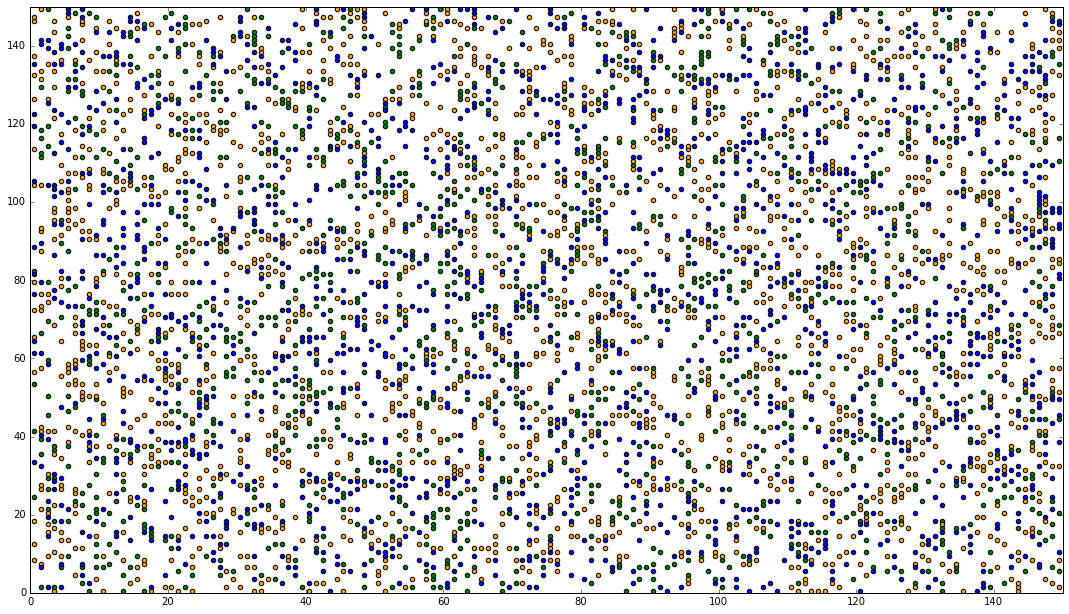

In [139]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.axis([0.0,150.0, 0.0,150.0])
for i, col in zip(range(0,K),['green','orange','blue','red','black']):
      #plt.scatter(sample_data[sample_data["cluster_id"]==i].loc[:,"Easting"],sample_data[sample_data["cluster_id"]==i].loc[:,"Northing"],c=col,marker='o')
    plt.scatter(sample[sample["cluster_id"]==i].loc[:,"Easting"],sample[sample["cluster_id"]==i].loc[:,"Northing"],c=col,marker='o')

for i in range(0,K): 
     plt.scatter(centers[i][0],centers[i][1],s=300,c='black',marker='*')

In [447]:
# aument costs _data 
regr = linear_model.LinearRegression()
X_train  = costs_data.loc[:10, ["gold_amount"]]
X_test =  costs_data.loc[11:, ["gold_amount"]]
for elev in ["low", "med", "high"]:
    y_train  = costs_data.loc[:10,elev]
    regr.fit(X_train,y_train)
    pred = regr.predict(X_test)
    costs_data.loc[11:,elev] = pred

A good cluster has elevation medium because lowest fixed costs highest gold amount. 

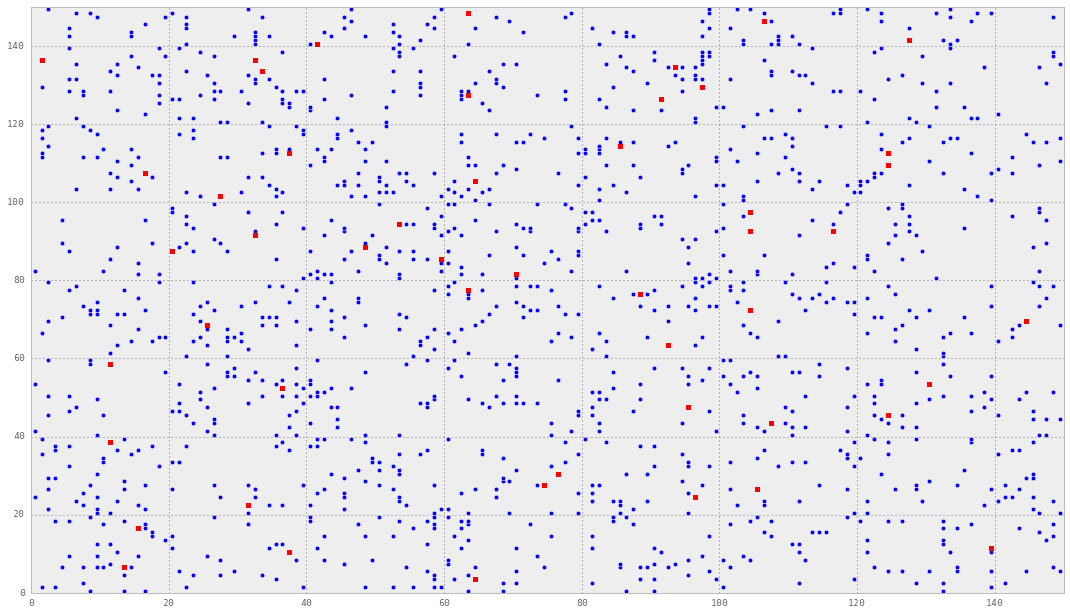

In [477]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.axis([0.0,150.0, 0.0,150.0])
plt.scatter(sample[sample["cluster_id"]==2].loc[:,"Easting"],sample[sample["cluster_id"]==2].loc[:,"Northing"],c=col,marker='o')
for index, parcel in auction_parcels.iterrows():
    plt.scatter(auction_parcels['Easting'], auction_parcels['Northing'],color='red',label=str(auction_parcels['parcel_id']))

In [507]:
l= []
trace = go.Scatter(
        x= auction_parcels['Easting'],
        y= auction_parcels['Northing'],
        mode= 'markers+text',
 marker= dict(size= 5,
                    line= dict(width=1),
                    opacity= 0.3,
              color = 'red'
                   ),
    #,name= y[i],
        text= auction_parcels['parcel_id'])
trace2 = go.Scatter(
    x = sample[sample["cluster_id"]==2].loc[:,"Easting"], 
    y = sample[sample["cluster_id"]==2].loc[:,"Northing"],
     mode= 'markers',
 marker= dict(size= 3,
                    line= dict(width=1),
                    opacity= 0.5,
                  color = 'blue'
                   )
)
l.append(trace)
l.append(trace2)
fig= go.Figure(data=l)
py.iplot(fig)    

This graphical analysis resulted in the following list of most interesting parcels to invest in:

firstfilter = [10226, 7837, 19114, 20194, 11489,10905,1790,13249,14154,12810,1614,12221]

## Let's predict whether a parcel contain a high amount of gold - WIP maybe 

In [51]:
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

One strategy would have to construct the minerals and ores as they are not present in the auction data, by using clustering on those features for example, assigning each parcel to a cluster and completing the auction parcel dataframe with the average value for each feature of each cluster. 

For simplicity we chose to only use the rocks categories features. Therefore we trained our classification models by extracting the previous features and normized those continuous values. 

In [178]:
features = auction_parcels.columns.tolist()
features.append("gold_available")
features.pop(1)
features.pop(1)
features.pop(0)
sample2 = sample_data.merge(elevation, on="parcel_id")
sample_set = sample2.loc[:,features]
sample_set.loc[:,["elevation","Arkonor","Mercoxit","Bistot","Crokite"]] = normalize(sample_set.loc[:,["elevation","Arkonor","Mercoxit","Bistot","Crokite"]], axis =0)

In [98]:
def label_gold_amount(row, threshold): 
    if row["gold_available"]  < threshold: 
        return 0 
    elif row["gold_available"]  >= threshold: 
        return 1 
sample_set["gold_available"] = sample_set.apply(lambda row: label_gold_amount(row, 10000), axis = 1)

In [104]:
def label_gold_amount(row): 
    if row["gold_available"]> 0 and row["gold_available"]  <= 10000: 
        return 0 
    elif row["gold_available"]> 10000 and row["gold_available"]  <= 20000: 
        return 1 
    else:
        return 2 
sample_set["gold_available"] = sample_set.apply(lambda row: label_gold_amount(row), axis = 1)

In [106]:
#sample_set
X_train, X_test, y_train, y_test = train_test_split(sample_set.iloc[:,0:5],sample_set.iloc[:,5],test_size=0.05)

In [107]:
logreg = LogisticRegression(multi_class='ovr') # 
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gs = GridSearchCV(estimator=logreg,param_grid= {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1','l2'] },scoring='accuracy',cv=5,n_jobs=-1)

In [108]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [109]:
gs.best_score_

0.52989473684210531

In [110]:
gs.best_params_

{'C': 100, 'penalty': 'l1'}

In [111]:
print('Test accuracy: %.2f %%' % (gs.score(X_test, y_test)*100))

Test accuracy: 53.20 %


In [124]:
sum(y_train == 2)

664

In [113]:
# X_test
auction_parcels_processedtmp = auction_parcels
auction_parcels_processedtmp.loc[:,["elevation","Arkonor","Mercoxit","Bistot","Crokite"]] = normalize(auction_parcels.loc[:,["elevation","Arkonor","Mercoxit","Bistot","Crokite"]], axis =0)
auction_parcels_processed = auction_parcels_processedtmp.loc[:,["parcel_id","elevation","Arkonor","Mercoxit","Bistot","Crokite"]]
auction_parcels_processed.head()

,parcel_id,elevation,Arkonor,Mercoxit,Bistot,Crokite
0,515,0.004863,0.141748,0.130815,0.134799,0.133601
1,914,0.164621,0.135439,0.134627,0.138784,0.142540
2,1538,0.263969,0.136843,0.142994,0.134596,0.127829
3,1790,0.099440,0.134950,0.141071,0.134163,0.136110
4,2416,0.332363,0.151359,0.150069,0.144281,0.141832


In [116]:
gs.predict(auction_parcels_processed.iloc[:,1:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [120]:
svc = SVC(random_state=1)
param_range2 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid2 = [{'C': param_range2,'kernel': ['linear']},
              {'C': param_range2,'kernel': ['rbf']}]
gs2 = GridSearchCV(estimator=svc,param_grid=param_grid2,scoring='accuracy',cv=3,n_jobs=-1)

In [121]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}, {'kernel': ['rbf'], 'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [122]:
gs2.predict(auction_parcels_processed.iloc[:,1:])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

## Clustering 2

In [225]:
sample2 = sample_data.merge(elevation, on="parcel_id")
features2 = features
sample_databis2 = sample2.loc[:,features2]
kmeans2 = KMeans(n_clusters=5).fit_predict(sample_databis2)
sample2["cluster_id"] = kmeans2

In [226]:
# statistics summary of the clustered data 
listo = sample2.columns.tolist()
listo.remove('Northing')
all_features = set(listo)
sample3 = sample2
reference = sample3.loc[:,all_features - set(features2)].groupby('cluster_id').mean()


In [1]:
# filtre = ['Arkonor','Mercoxit','Bistot','Crokite', 'elevation']
# filtros = ['Arkonor','Mercoxit','Bistot','Crokite', 'elevation', 'cluster_id']
# refera = sample3.loc[:, filtros].groupby('cluster_id').describe()

# def assign_cluster(row): 
#     for i in xrange(5):
#         for val in filtre: 
#             print(i + " " + val )
#             # if(row[val] > refera.loc[i, :].min()[val] and row[val] < refera.loc[i, :].max()[val]):
#                 # row['cluster_id'] = i

# auction_pracels2 = auction_parcels 
# auction_pracels2.apply(lambda row: assign_cluster(row), axis = 1)
# # refera.loc[0, :].min()

In [ ]:
missing_list = reference.columns.tolist()
def enrich_auction(row): 
    for i in xrange(5):
        if row['cluster_id'] == i:
            row[missing_list] = reference.loc[i, :]

In [236]:
#acution_pracels2 = auction_parcels 
#acution_pracels2.apply(lambda row: enrich_auction(row), axis = 1)

In [259]:

# sample2.loc[:,features.append['cluster_id']]

In [264]:
refera.min()

Arkonor         7.092485
Bistot         10.804418
Crokite         5.419970
Mercoxit        7.515567
elevation   -1359.020531
dtype: float64

In [302]:
for i in xrange(5):
      for val in filtre: 
            print(str(i) + " " + val )

0 Arkonor
0 Mercoxit
0 Bistot
0 Crokite
0 elevation
1 Arkonor
1 Mercoxit
1 Bistot
1 Crokite
1 elevation
2 Arkonor
2 Mercoxit
2 Bistot
2 Crokite
2 elevation
3 Arkonor
3 Mercoxit
3 Bistot
3 Crokite
3 elevation
4 Arkonor
4 Mercoxit
4 Bistot
4 Crokite
4 elevation
